# Module 06: Regularized Regression

## Prerequisites

In [1]:
# Helper packages
import numpy as np
import pandas as pd
from plotnine import *

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [2]:
# Ames housing data
ames = pd.read_csv("../../00-data/ML/ames.csv")

# create train/test split
train, test = train_test_split(ames, train_size=0.7, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop("Sale_Price", axis=1)
y_train = train[["Sale_Price"]]

## Implementation

### Ridge

In [3]:
# Step 1: get features of interest
features = X_train[["Gr_Liv_Area", "Year_Built", "Garage_Cars", "Garage_Area"]]

# Step 2: standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(features)

# Step 3: create model object
ridge_mod = Ridge(alpha=1)

# Step 4: fit/train model
ridge_fit = ridge_mod.fit(X_train_scaled, y_train)

In [4]:
ridge_fit.coef_

array([[39936.69788684, 24309.03872837,  7826.82312427, 14097.84660676]])

### Lasso

In [5]:
lasso_mod = Lasso(alpha=1)
lasso_fit = lasso_mod.fit(X_train_scaled, y_train)

# fit coefficients
lasso_fit.coef_

array([39959.05154477, 24323.04132533,  7800.91630771, 14109.32332939])

### Elastic net

In [6]:
en_mod = ElasticNet(alpha=1)
en_fit = en_mod.fit(X_train_scaled, y_train)

# fit coefficients
en_fit.coef_

array([26484.60939236, 16829.83794631, 12943.86385538, 13064.02074165])

## Tuning

### Tuning regularization strength

In [7]:
# create new feature set with encoded features
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
    ("scale", StandardScaler(), selector(dtype_include="number")),
    ("one-hot", OneHotEncoder(), selector(dtype_include="object"))
  ])

X_train_encoded = preprocessor.fit_transform(X_train)

In [8]:
# create model object
ridge_mod = Ridge()

# define loss function
loss = 'neg_root_mean_squared_error'

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# Create grid of hyperparameter values
hyper_grid = {'alpha': 10**np.linspace(10, -5, 50)*0.5}

In [9]:
grid_search = GridSearchCV(ridge_mod, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train_encoded, y_train)

# Optimal penalty parameter in grid search
results.best_estimator_

Ridge(alpha=6.628556827950554)

In [10]:
# Best model's cross validated RMSE
round(abs(results.best_score_), 2)

30095.73

## Tuning regularization type & strength

In [11]:
# create model object
mod = ElasticNet(tol=0.01)

# Create grid of hyperparameter values
hyper_grid = {
  'alpha': 10**np.linspace(10, -5, 10)*0.5,
  'l1_ratio': (0, 0.25, 0.5, 0.75 , 1)
  }

In [12]:
# 5-fold CV grid search
grid_search = GridSearchCV(mod, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train_encoded, y_train)

# Optimal penalty parameter in grid search
results.best_estimator_

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5488081309585.288, tolerance: 109761626319.54747
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5314682258371.3, tolerance: 106293645290.79907
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5396489650199.965, tolerance: 107929793130.18071
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5465887888069.524, tolerance: 109317757889.3503

ElasticNet(alpha=23.207944168063865, l1_ratio=1, tol=0.01)

In [13]:
# Best model's cross validated RMSE
round(abs(results.best_score_), 2)

29552.31

## Feature importance

In [14]:
# get feature names
feat_names = ColumnTransformer(
  remainder="passthrough",
  transformers=[
      ("one-hot", OneHotEncoder(), selector(dtype_include="object"))
  ]).fit(X_train).get_feature_names()

# create DataFrame with feature name and coefficients from best model
coef = pd.DataFrame({'feature': feat_names,
                     'coef': results.best_estimator_.coef_})

# filter for the top 25
coef['abs_coef'] = coef['coef'].abs()
coef['impact'] = np.where(coef['coef']>0, 'positive', 'negative')

top_25_features = coef.nlargest(25, 'abs_coef')
top_25_features.head()

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,feature,coef,abs_coef,impact
163,one-hot__x19_Stone,-550233.433278,550233.433278,negative
327,Bsmt_Full_Bath,-390163.485390,390163.485390,negative
121,one-hot__x15_Very_Good,-117117.158839,117117.158839,negative
89,one-hot__x11_RRAn,99099.308207,99099.308207,positive
317,Year_Remod_Add,80523.104479,80523.104479,positive


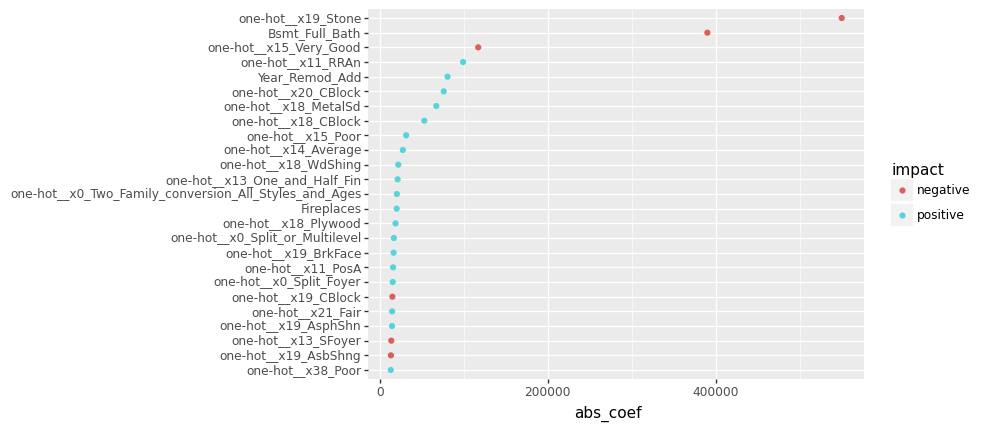

<ggplot: (17592034321568)>

In [15]:
(ggplot(top_25_features, aes(x='abs_coef', y='reorder(feature, abs_coef)', color='impact', fill='impact'))
 + geom_point()
 + labs(y=None))

## Exercises

Using the boston housing dataset:

1. Apply a ridge model with glmnet with `medv` being the response variable.
   - What is the minimum MSE?
   - What is the minimum MSE within 1 standard error?
   - What are the lambda values for these MSEs?
2. Apply a lasso model with glmnet.
   - What is the minimum MSE?
   - What is the minimum MSE within 1 standard error?
   - What are the lambda values for these MSEs?
3. Perform a grid search across alpha parameter values ranging between 0–1.
   - What is the optimal alpha and lambda values?
   - What is the MSE and RMSE for this optimal model?
   - How does it compare to your previous models?
4. Plot the top 10 most influential features. Do these features have positive or negative impacts on your response variable?